<a href="https://colab.research.google.com/github/J-riah/DAV_Project/blob/main/DAV_IPL_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import yellowbrick as yb
import plotly.offline as py
import plotly.graph_objs as go

from yellowbrick.contrib.scatter import ScatterVisualizer
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates
from yellowbrick.model_selection import CVScores
from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.manifold import Manifold

py.init_notebook_mode(connected=True)

import warnings
warnings.simplefilter('ignore')

In [62]:
data1 = pd.read_csv('matches.csv')
data2 = pd.read_csv('deliveries.csv')

In [63]:
data1.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [64]:
data1.describe()

,id,season,dl_applied,win_by_runs,win_by_wickets
count,756.000000,756.000000,756.000000,756.000000,756.000000
mean,1792.178571,2013.444444,0.025132,13.283069,3.350529
std,3464.478148,3.366895,0.156630,23.471144,3.387963
min,1.000000,2008.000000,0.000000,0.000000,0.000000
25%,189.750000,2011.000000,0.000000,0.000000,0.000000
50%,378.500000,2013.000000,0.000000,0.000000,4.000000
75%,567.250000,2016.000000,0.000000,19.000000,6.000000
max,11415.000000,2019.000000,1.000000,146.000000,10.000000


In [65]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               756 non-null    int64 
 1   season           756 non-null    int64 
 2   city             749 non-null    object
 3   date             756 non-null    object
 4   team1            756 non-null    object
 5   team2            756 non-null    object
 6   toss_winner      756 non-null    object
 7   toss_decision    756 non-null    object
 8   result           756 non-null    object
 9   dl_applied       756 non-null    int64 
 10  winner           752 non-null    object
 11  win_by_runs      756 non-null    int64 
 12  win_by_wickets   756 non-null    int64 
 13  player_of_match  752 non-null    object
 14  venue            756 non-null    object
 15  umpire1          754 non-null    object
 16  umpire2          754 non-null    object
 17  umpire3          119 non-null    ob

In [66]:
#check null values
data1.isnull().sum()

id                   0
season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               4
win_by_runs          0
win_by_wickets       0
player_of_match      4
venue                0
umpire1              2
umpire2              2
umpire3            637
dtype: int64

In [67]:
# became MOTM most
data1.player_of_match.value_counts()

player_of_match
CH Gayle          21
AB de Villiers    20
RG Sharma         17
MS Dhoni          17
DA Warner         17
                  ..
PD Collingwood     1
NV Ojha            1
AC Voges           1
J Theron           1
S Hetmyer          1
Name: count, Length: 226, dtype: int64

In [68]:
# became winner most
data1.winner.value_counts()

winner
Mumbai Indians                 109
Chennai Super Kings            100
Kolkata Knight Riders           92
Royal Challengers Bangalore     84
Kings XI Punjab                 82
Rajasthan Royals                75
Delhi Daredevils                67
Sunrisers Hyderabad             58
Deccan Chargers                 29
Gujarat Lions                   13
Pune Warriors                   12
Rising Pune Supergiant          10
Delhi Capitals                  10
Kochi Tuskers Kerala             6
Rising Pune Supergiants          5
Name: count, dtype: int64

In [69]:
# most of the matches are played at
data1.venue.value_counts()

venue
Eden Gardens                                            77
M Chinnaswamy Stadium                                   73
Wankhede Stadium                                        73
Feroz Shah Kotla                                        67
Rajiv Gandhi International Stadium, Uppal               56
MA Chidambaram Stadium, Chepauk                         49
Sawai Mansingh Stadium                                  47
Punjab Cricket Association Stadium, Mohali              35
Maharashtra Cricket Association Stadium                 21
Subrata Roy Sahara Stadium                              17
Dr DY Patil Sports Academy                              17
Kingsmead                                               15
Punjab Cricket Association IS Bindra Stadium, Mohali    14
SuperSport Park                                         12
Sardar Patel Stadium, Motera                            12
Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium     11
Brabourne Stadium                                 

In [70]:
# the umpire1 most of the time
data1.umpire1.value_counts()

umpire1
HDPK Dharmasena    73
Asad Rauf          51
S Ravi             49
AK Chaudhary       43
Aleem Dar          38
                   ..
Nanda Kishore       1
SJA Taufel          1
A Nanda Kishore     1
SL Shastri          1
Sundaram Ravi       1
Name: count, Length: 61, dtype: int64

In [71]:
# the umpire2 most of the time
data1.umpire2.value_counts()

umpire2
C Shamshuddin       57
S Ravi              57
SJA Taufel          54
RJ Tucker           38
CK Nandan           36
                    ..
Kumar Dharmasena     1
SD Fry               1
SJ Davis             1
Subroto Das          1
Ian Gould            1
Name: count, Length: 65, dtype: int64

In [72]:
# the umpire3 most of the time
data1.umpire3.value_counts()

umpire3
Nitin Menon                10
O Nandan                   10
C Shamshuddin              10
Anil Chaudhary              9
S Ravi                      8
Vineet Kulkarni             8
Bruce Oxenford              7
Yeshwant Barde              7
Anil Dandekar               7
Chris Gaffaney              6
Rod Tucker                  5
Marais Erasmus              5
Nigel Llong                 4
A Nanda Kishore             3
Nanda Kishore               3
Ian Gould                   3
A.D Deshmukh                2
K Ananthapadmanabhan        2
Virender Kumar Sharma       2
Kumar Dharmasena            2
Ulhas Gandhe                2
KN Anantapadmanabhan        1
Sundaram Ravi               1
KN Ananthapadmanabhan       1
Chettithody Shamshuddin     1
Name: count, dtype: int64

In [73]:
# unique season with no. of records
data1.season.value_counts()

season
2013    76
2012    74
2011    73
2010    60
2014    60
2016    60
2018    60
2019    60
2017    59
2015    59
2008    58
2009    57
Name: count, dtype: int64

In [74]:
# unique toss_decision with no. of records
data1.toss_decision.value_counts()

toss_decision
field    463
bat      293
Name: count, dtype: int64

In [75]:
# unique result with no. of records
data1.result.value_counts()

result
normal       743
tie            9
no result      4
Name: count, dtype: int64

In [76]:
# unique dl_applied with no. of records
data1.dl_applied.value_counts()

dl_applied
0    737
1     19
Name: count, dtype: int64

In [77]:
# unique team1 with no. of records
data1.team1.value_counts()

team1
Mumbai Indians                 101
Kings XI Punjab                 91
Chennai Super Kings             89
Royal Challengers Bangalore     85
Kolkata Knight Riders           83
Delhi Daredevils                72
Rajasthan Royals                67
Sunrisers Hyderabad             63
Deccan Chargers                 43
Pune Warriors                   20
Gujarat Lions                   14
Rising Pune Supergiant           8
Kochi Tuskers Kerala             7
Rising Pune Supergiants          7
Delhi Capitals                   6
Name: count, dtype: int64

In [78]:
# total winner count
len(list(data1.winner.value_counts()))

15

In [79]:
# unique winner with no. of records
data1.winner.value_counts()

winner
Mumbai Indians                 109
Chennai Super Kings            100
Kolkata Knight Riders           92
Royal Challengers Bangalore     84
Kings XI Punjab                 82
Rajasthan Royals                75
Delhi Daredevils                67
Sunrisers Hyderabad             58
Deccan Chargers                 29
Gujarat Lions                   13
Pune Warriors                   12
Rising Pune Supergiant          10
Delhi Capitals                  10
Kochi Tuskers Kerala             6
Rising Pune Supergiants          5
Name: count, dtype: int64

In [80]:
# drop columns
data1.drop('id', axis=1, inplace=True)
data1.drop('city', axis=1, inplace=True)
data1.drop('date', axis=1, inplace=True)
data1.drop('venue', axis=1, inplace=True)
data1.drop('umpire1', axis=1, inplace=True)
data1.drop('umpire2', axis=1, inplace=True)
data1.drop('umpire3', axis=1, inplace=True)

In [81]:
data1.head()

,season,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match
0,2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh
1,2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith
2,2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn
3,2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell
4,2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav


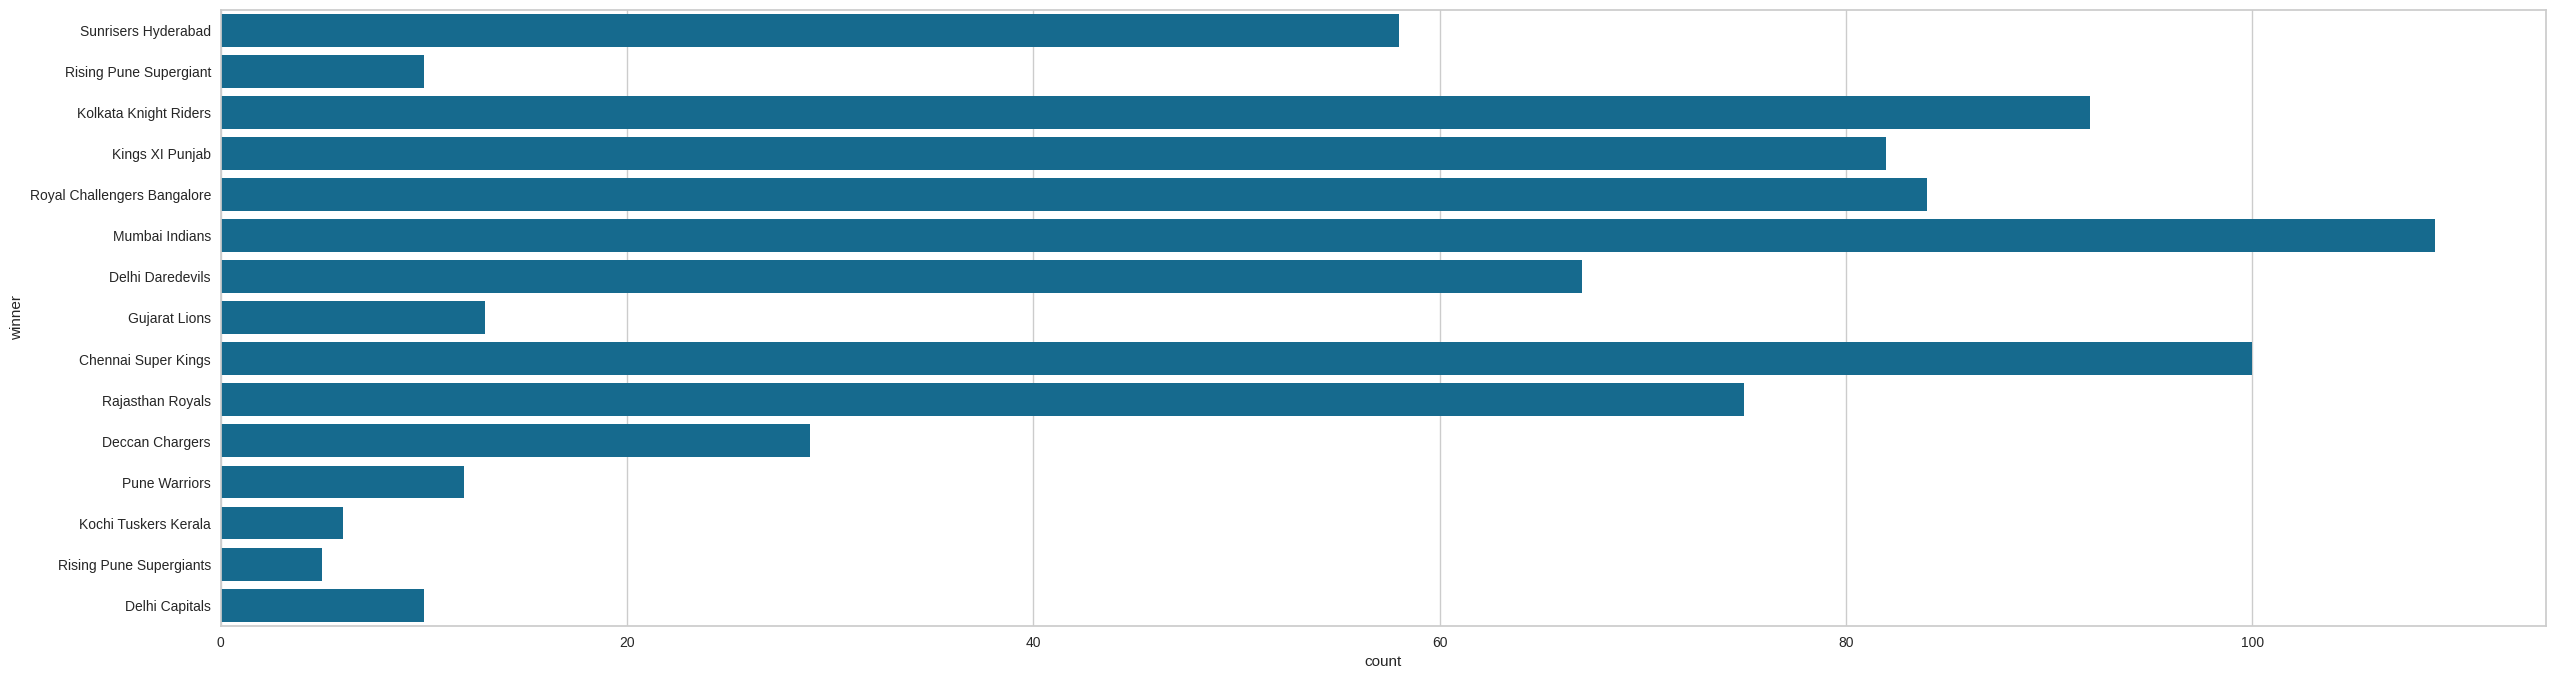

In [82]:
# visualize the target variable
g = sns.countplot(data1['winner'])
plt.gcf().set_size_inches(30, 8)
plt.show()

In [83]:
# getting all unique values
a_team = list(data1.team1.unique())
a_season = list(data1.season.unique())
a_toss_decision = list(data1.toss_decision.unique())
a_result = list(data1.result.unique())

In [84]:
# label encoding for teams
def idx(a, ter):
  for i in range(0, len(a)):
    if a[i] == ter:
      return i+1

In [85]:
# substituting values
for i in range(0, len(data1.team1)):
  data1.team1[i] = idx(a_team, data1.team1[i])

for i in range(0, len(data1.team2)):
  data1.team2[i] = idx(a_team, data1.team2[i])

for i in range(0, len(data1.toss_winner)):
  data1.toss_winner[i] = idx(a_team, data1.toss_winner[i])

for i in range(0, len(data1.winner)):
  data1.winner[i] = idx(a_team, data1.winner[i])

for i in range(0, len(data1.season)):
  data1.season[i] = idx(a_season, data1.season[i])

for i in range(0, len(data1.toss_decision)):
  data1.toss_decision[i] = idx(a_toss_decision, data1.toss_decision[i])

for i in range(0, len(data1.result)):
  data1.result[i] = idx(a_result, data1.result[i])

In [26]:
# correct pred for draw match
for i in range(0, len(data1.winner)):
  if data1.winner[i] == None:
    data1.winner[i] = 0

In [91]:
# Replace 'None' with a placeholder value (-1)
data1['winner'] = data1['winner'].fillna(-1)

# Convert dtype from object to int
data1['winner'] = data1['winner'].astype(int)

In [92]:
# change the dtype from object to int
data1['team1'] = data1['team1'].astype(str).astype(int)
data1['team2'] = data1['team2'].astype(str).astype(int)
data1['toss_winner'] = data1['toss_winner'].astype(str).astype(int)
data1['season'] = data1['season'].astype(str).astype(int)
data1['toss_decision'] = data1['toss_decision'].astype(str).astype(int)
data1['result'] = data1['result'].astype(str).astype(int)
data1['winner'] = data1['winner'].astype(str).astype(int)

In [28]:
data1.head()

,season,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match
0,1,1,5,5,1,1,0,1,35,0,Yuvraj Singh
1,1,2,4,4,1,1,0,4,0,7,SPD Smith
2,1,3,6,6,1,1,0,6,0,10,CA Lynn
3,1,4,8,8,1,1,0,8,0,6,GJ Maxwell
4,1,5,7,5,2,1,0,5,15,0,KM Jadhav


In [93]:
# splitting data
X = data1.iloc[:, :-4]
y = data1.iloc[:, 7]


<Axes: >

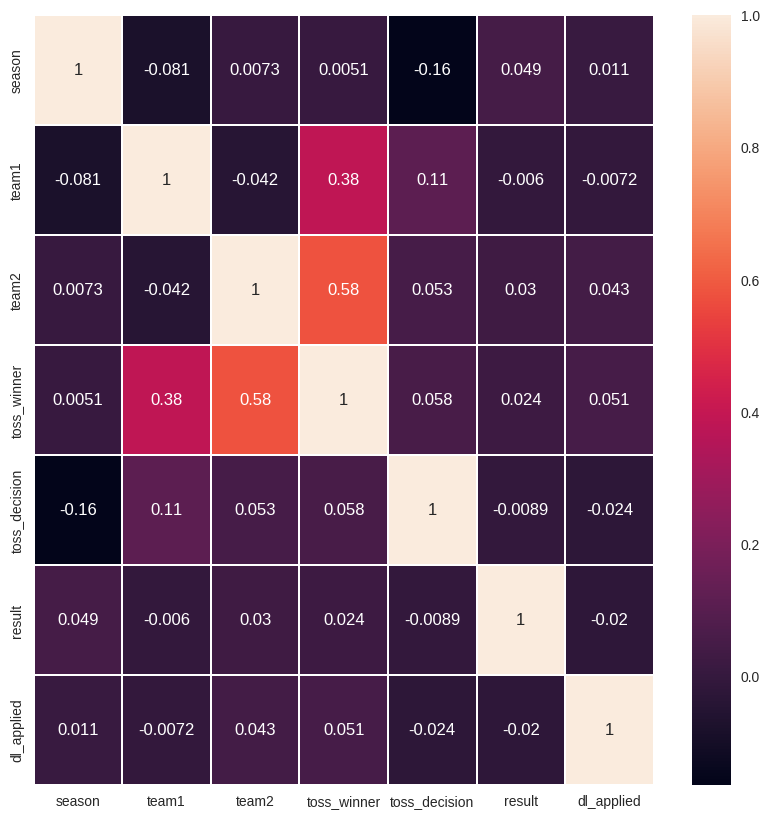

In [94]:
# plotting heatmap
corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, linewidths=0.05)

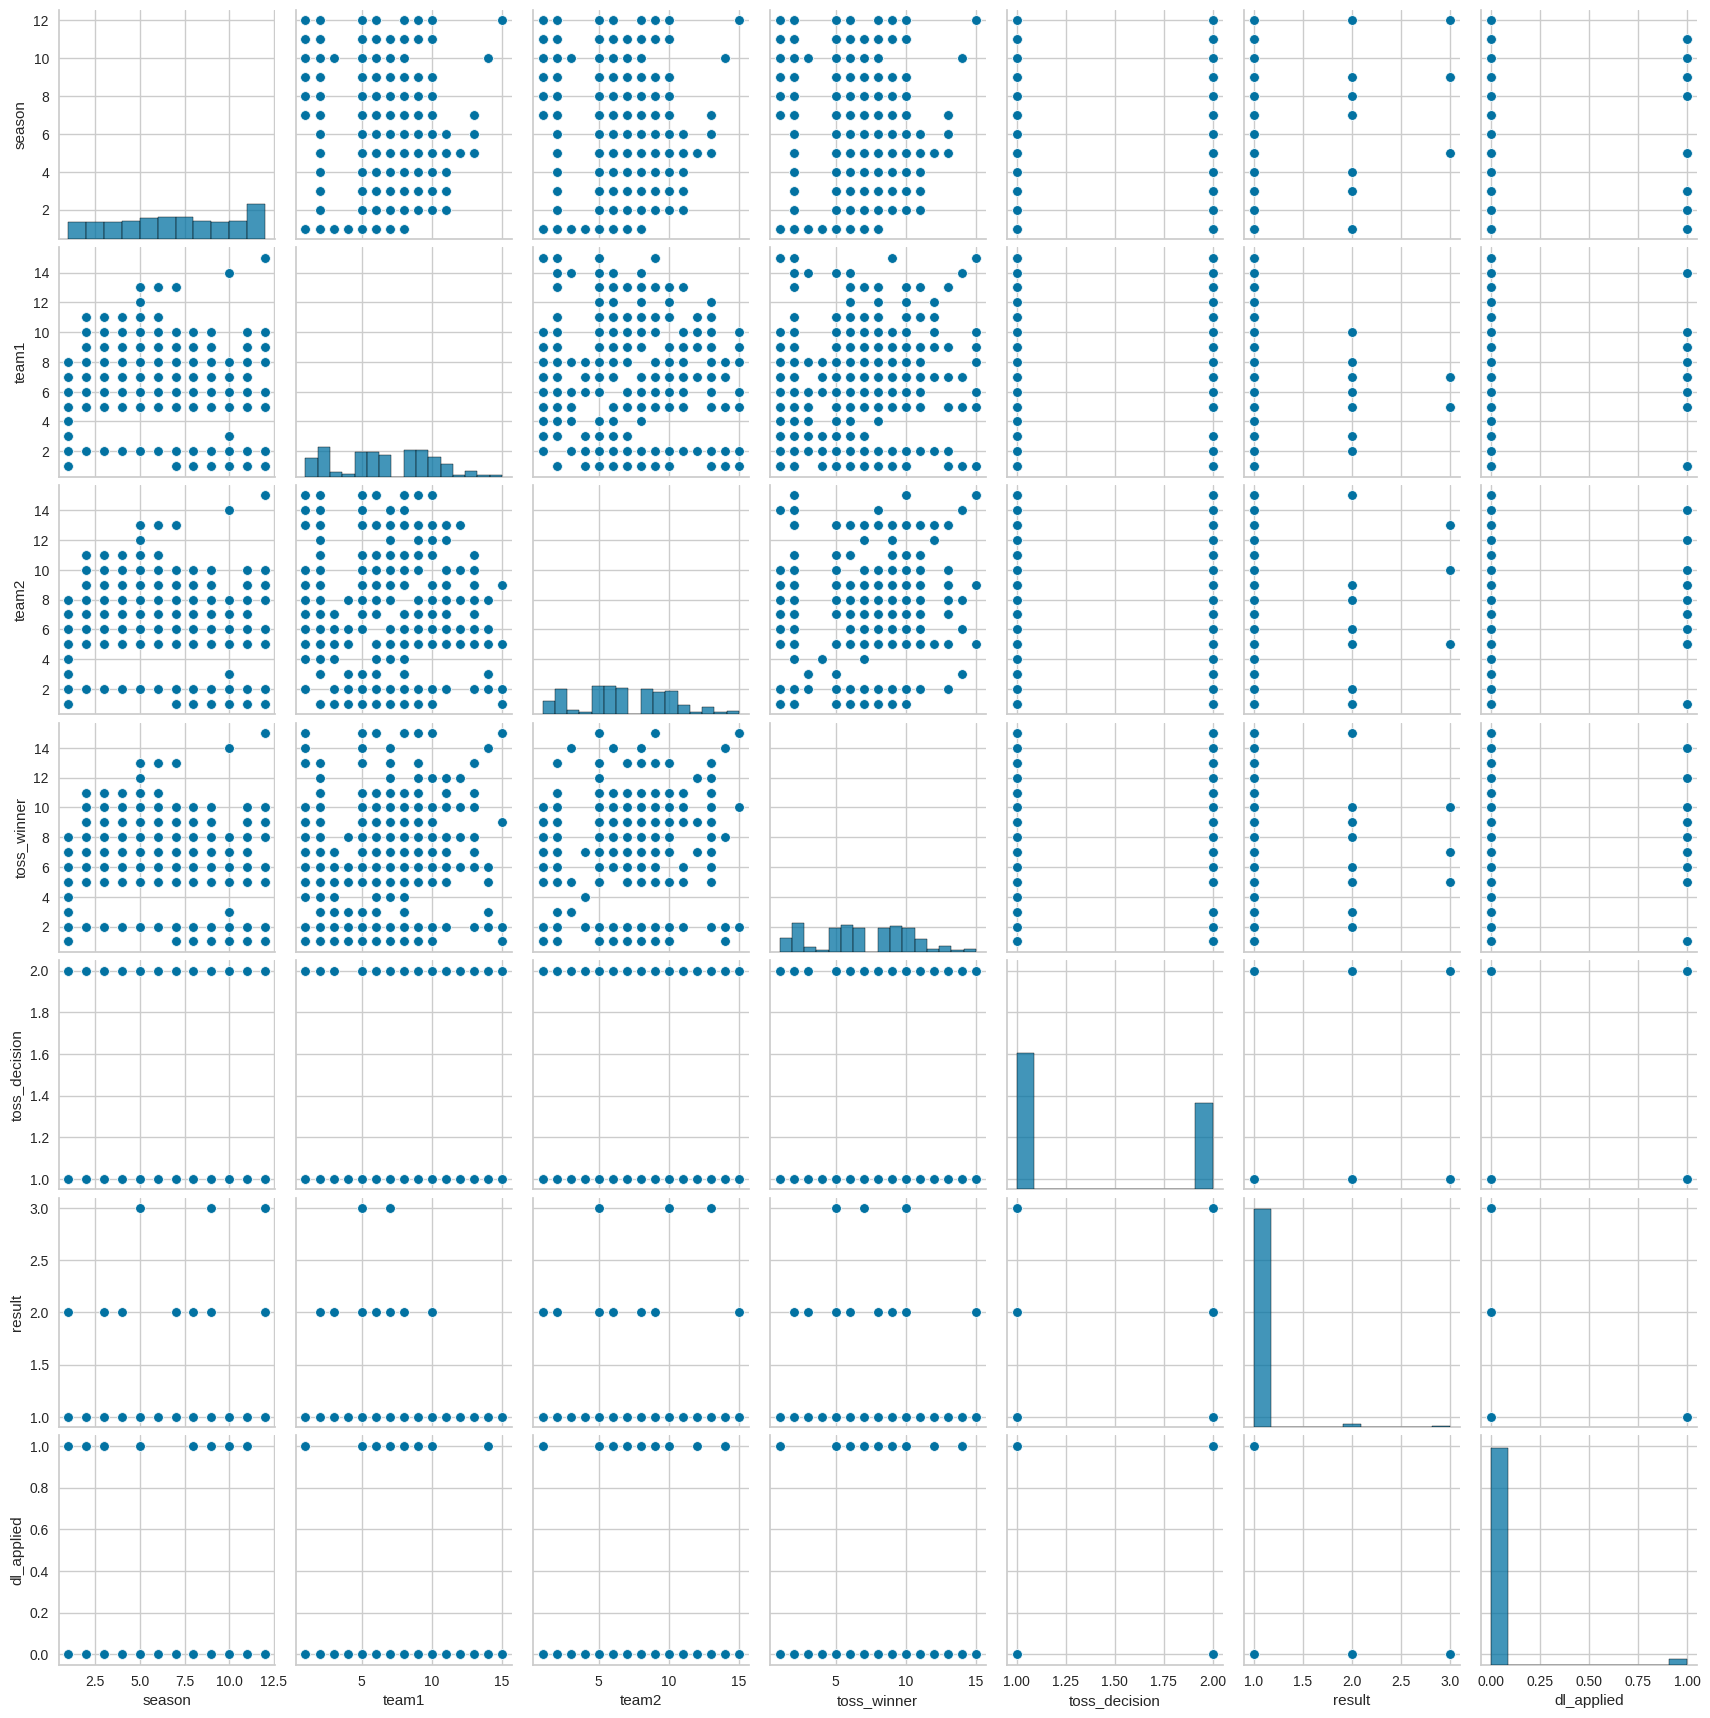

In [95]:
# checking individual relations using pairplot
sns.pairplot(X)

<Figure size 800x550 with 0 Axes>

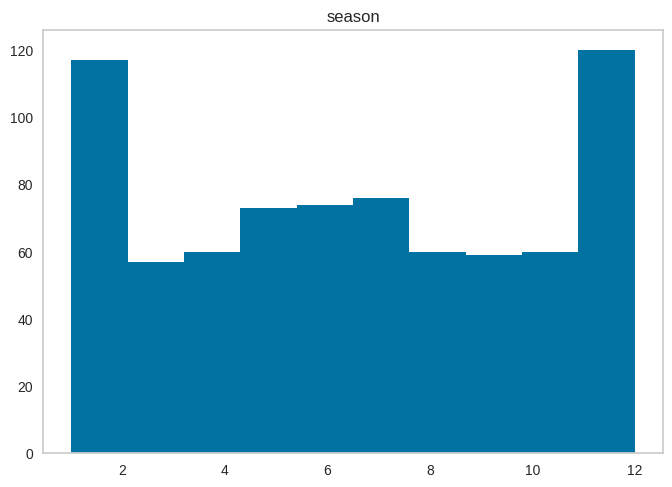

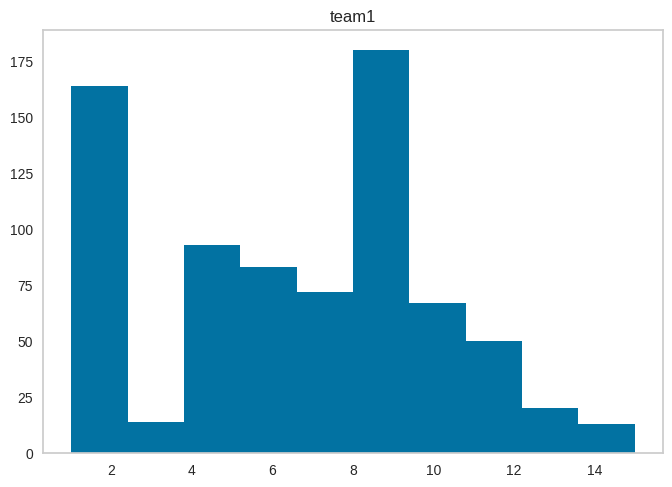

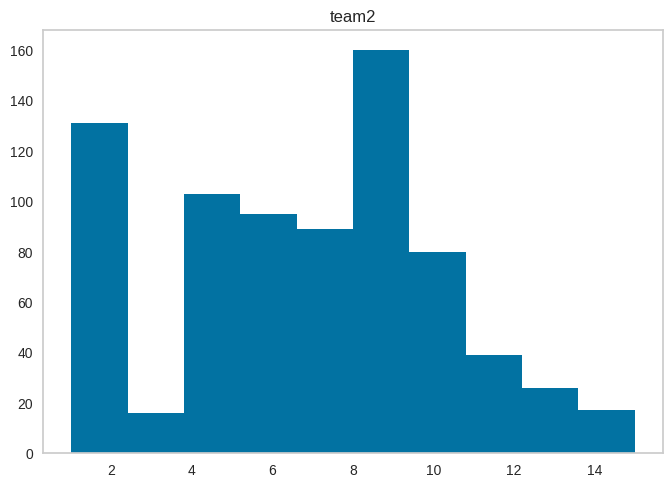

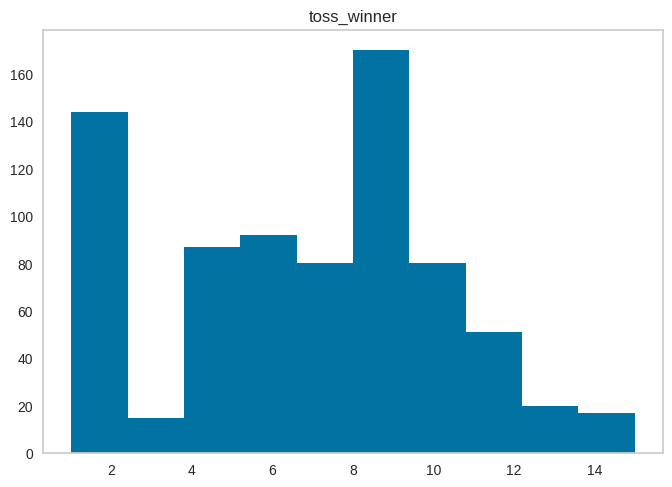

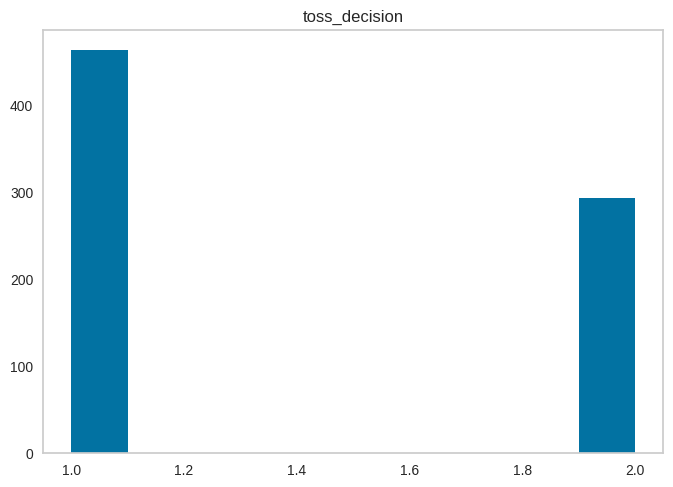

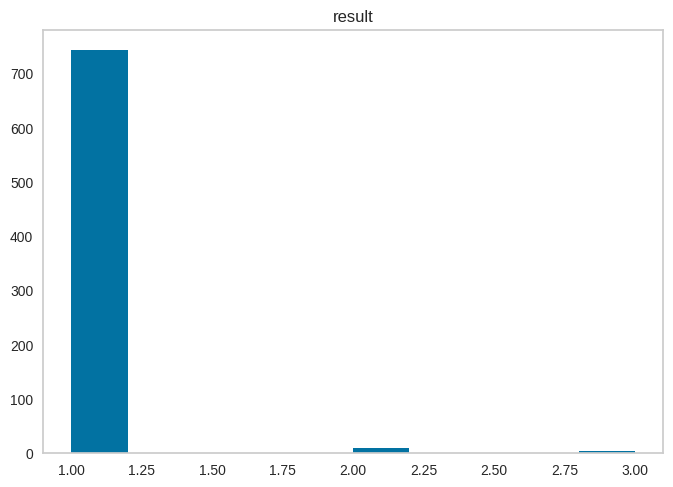

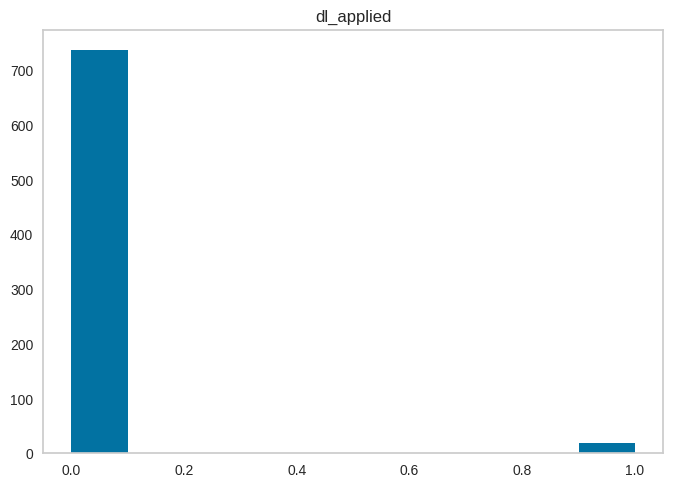

In [96]:
# checking individual distribution using histplot

for id, column in enumerate(X.columns):
    plt.figure(id)
    X.hist(column=column, grid=False)

In [97]:
# finding important feature

li =[]
rank = SelectKBest(chi2, k=5)
fit = rank.fit(X, y)

for i, (score, feature) in enumerate(zip(rank.scores_, X.columns)):
    li.append((score, feature))

df1 = pd.DataFrame(li)
df1.sort_values(by=[0], ascending = False)

,0,1
2,334.227411,team2
3,333.083925,toss_winner
1,331.993685,team1
0,179.505952,season
6,39.828872,dl_applied
5,15.536320,result
4,6.945487,toss_decision


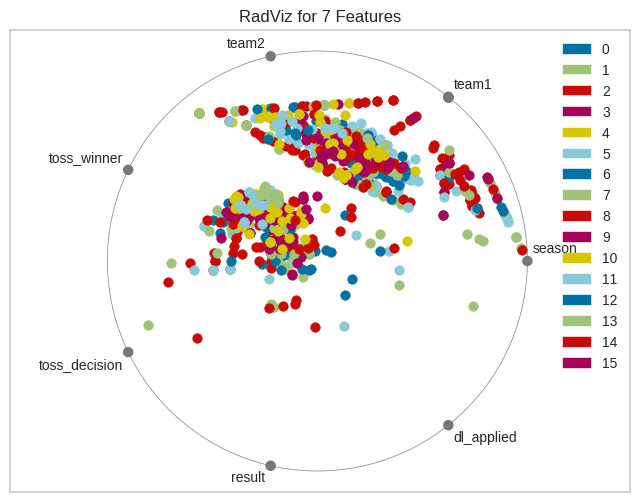

<Axes: title={'center': 'RadViz for 7 Features'}>

In [98]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
features = ['season', 'team1', 'team2', 'toss_winner', 'toss_decision', 'result', 'dl_applied']
visualizer = RadViz(classes=classes, features=features, size=(800, 600))
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

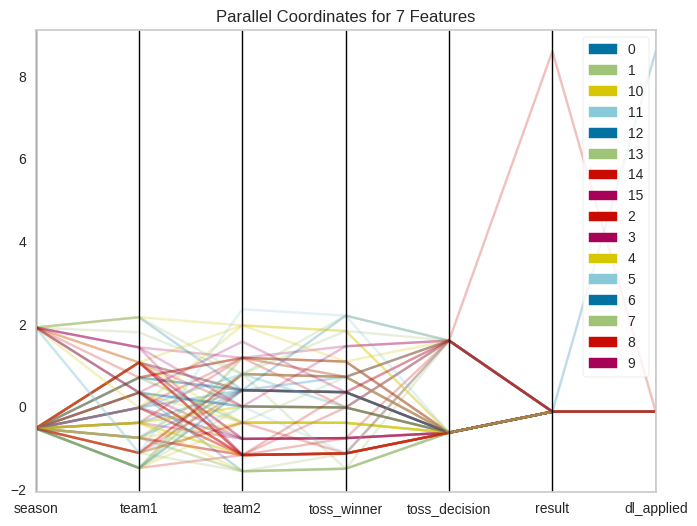

<Axes: title={'center': 'Parallel Coordinates for 7 Features'}>

In [99]:
# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes,
    features=features,
    normalize='standard',
    sample = 0.1,
    size=(800, 600)
)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

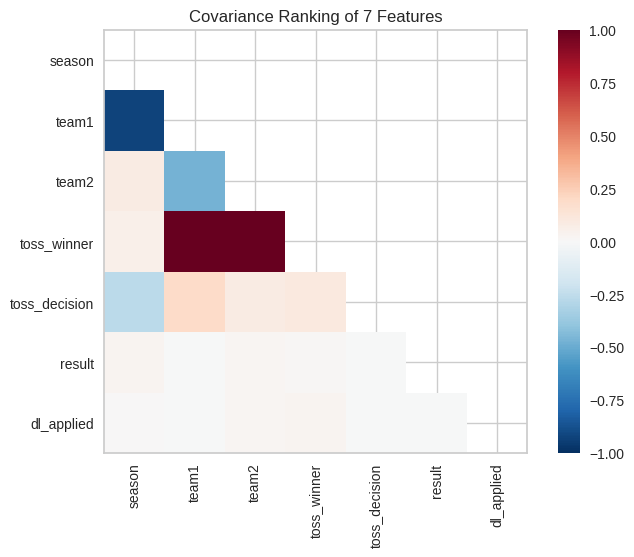

<Axes: title={'center': 'Covariance Ranking of 7 Features'}>

In [100]:
visualizer = Rank2D(features=features, algorithm='covariance')
visualizer.fit(X, y)
visualizer.transform(X.values)
visualizer.poof()

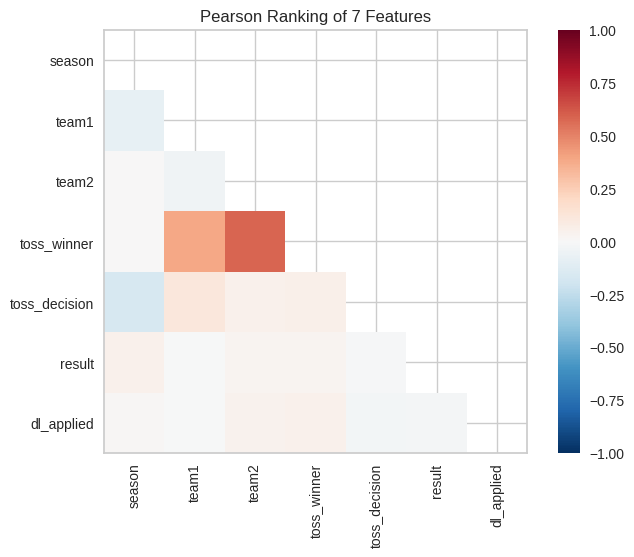

<Axes: title={'center': 'Pearson Ranking of 7 Features'}>

In [101]:

visualizer = Rank2D(features=features, algorithm='pearson')
visualizer.fit(X, y)
visualizer.transform(X.values)
visualizer.poof()


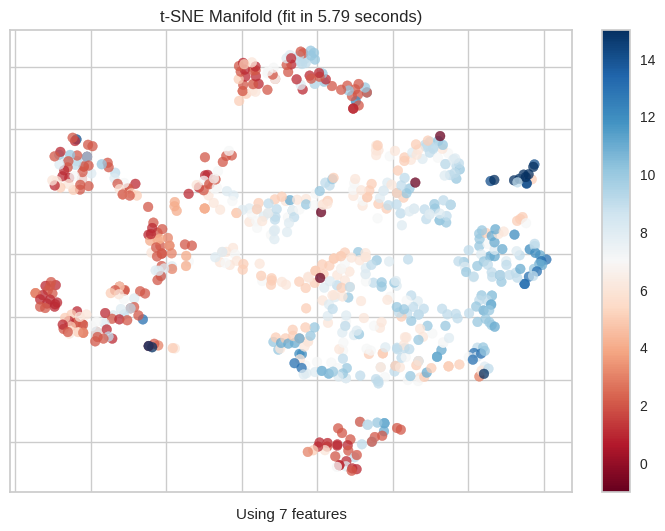

<Axes: title={'center': 't-SNE Manifold (fit in 5.79 seconds)'}, xlabel='Using 7 features'>

In [102]:
visualizer = Manifold(manifold='tsne', target='discrete', classes=classes, size=(800, 600))
visualizer.fit_transform(X,y)
visualizer.poof()

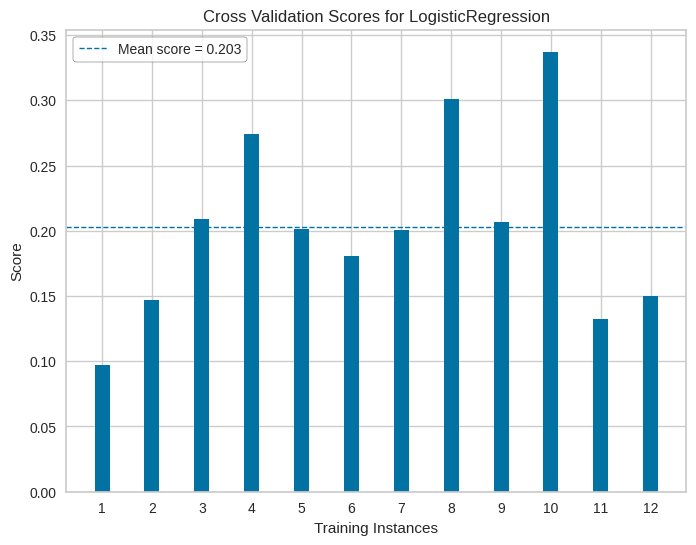

<Axes: title={'center': 'Cross Validation Scores for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [103]:
# new figure and axes
_, ax = plt.subplots()
# cross-validation strategy
cv = StratifiedKFold(12)
# CV score visualizer
oz = CVScores(
    LogisticRegression(), ax=ax, cv=cv,
    scoring='f1_weighted', size=(800,600)
)
oz.fit(X, y)
oz.poof()


**DATASET-2**

In [104]:
data2.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [105]:
data2.shape

(179078, 21)

In [106]:
data2.describe()

,match_id,inning,over,ball,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs
count,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000
mean,1802.252957,1.482952,10.162488,3.615587,0.000452,0.036721,0.004936,0.021136,0.004183,0.000056,1.246864,0.067032,1.313897
std,3472.322805,0.502074,5.677684,1.806966,0.021263,0.251161,0.116480,0.194908,0.070492,0.016709,1.608270,0.342553,1.605422
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,190.000000,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,379.000000,1.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,567.000000,2.000000,15.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,11415.000000,5.000000,20.000000,9.000000,1.000000,5.000000,4.000000,5.000000,5.000000,5.000000,7.000000,7.000000,10.000000


In [107]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179078 entries, 0 to 179077
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          179078 non-null  int64 
 1   inning            179078 non-null  int64 
 2   batting_team      179078 non-null  object
 3   bowling_team      179078 non-null  object
 4   over              179078 non-null  int64 
 5   ball              179078 non-null  int64 
 6   batsman           179078 non-null  object
 7   non_striker       179078 non-null  object
 8   bowler            179078 non-null  object
 9   is_super_over     179078 non-null  int64 
 10  wide_runs         179078 non-null  int64 
 11  bye_runs          179078 non-null  int64 
 12  legbye_runs       179078 non-null  int64 
 13  noball_runs       179078 non-null  int64 
 14  penalty_runs      179078 non-null  int64 
 15  batsman_runs      179078 non-null  int64 
 16  extra_runs        179078 non-null  int

In [108]:
# checking null values
data2.isnull().sum()

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
is_super_over            0
wide_runs                0
bye_runs                 0
legbye_runs              0
noball_runs              0
penalty_runs             0
batsman_runs             0
extra_runs               0
total_runs               0
player_dismissed    170244
dismissal_kind      170244
fielder             172630
dtype: int64

In [109]:
# dismissed values
data2.player_dismissed.value_counts()

player_dismissed
SK Raina      162
RG Sharma     155
RV Uthappa    153
V Kohli       143
S Dhawan      137
             ... 
S Randiv        1
R Ninan         1
B Sumanth       1
C Madan         1
S Singh         1
Name: count, Length: 487, dtype: int64

In [110]:
# dismissed types
data2.dismissal_kind.value_counts()

dismissal_kind
caught                   5348
bowled                   1581
run out                   852
lbw                       540
stumped                   278
caught and bowled         211
retired hurt               12
hit wicket                 10
obstructing the field       2
Name: count, dtype: int64

In [111]:
# get fielder names
data2.fielder.value_counts()

fielder
MS Dhoni               159
KD Karthik             152
RV Uthappa             125
SK Raina               115
AB de Villiers         114
                      ... 
RJ Peterson              1
P Dogra (sub)            1
NLTC Perera (sub)        1
LA Pomersbach (sub)      1
S Warrier                1
Name: count, Length: 499, dtype: int64

In [112]:
# get batsman names (stays for long time)
data2.batsman.value_counts()

batsman
V Kohli          4211
SK Raina         4044
RG Sharma        3816
S Dhawan         3776
G Gambhir        3524
                 ... 
K Ahmed             1
U Kaul              1
DP Vijaykumar       1
P Raj               1
LH Ferguson         1
Name: count, Length: 516, dtype: int64

In [113]:
# get bowler name (stays for long time)
data2.bowler.value_counts()

bowler
Harbhajan Singh     3451
A Mishra            3172
PP Chawla           3157
R Ashwin            3016
SL Malinga          2974
                    ... 
Y Gnaneswara Rao       6
P Prasanth             6
SPD Smith              2
SN Khan                2
AC Gilchrist           1
Name: count, Length: 405, dtype: int64

In [114]:
# total wide run
data2.wide_runs.value_counts()

wide_runs
0    173673
1      4915
2       230
5       208
3        47
4         5
Name: count, dtype: int64

In [115]:
# total bye_runs run
data2.bye_runs.value_counts()

bye_runs
0    178598
1       324
4       123
2        31
3         2
Name: count, dtype: int64

In [116]:
# total legbye_runs run
data2.legbye_runs.value_counts()


legbye_runs
0    176141
1      2558
4       220
2       138
3        17
5         4
Name: count, dtype: int64

In [117]:
# total no balls
data2.noball_runs.value_counts()

noball_runs
0    178364
1       698
2         9
5         6
3         1
Name: count, dtype: int64

In [118]:
# drop columns
data2.drop('match_id', axis=1, inplace=True)
data2.drop('player_dismissed', axis=1, inplace=True)
data2.drop('dismissal_kind', axis=1, inplace=True)
data2.drop('fielder', axis=1, inplace=True)

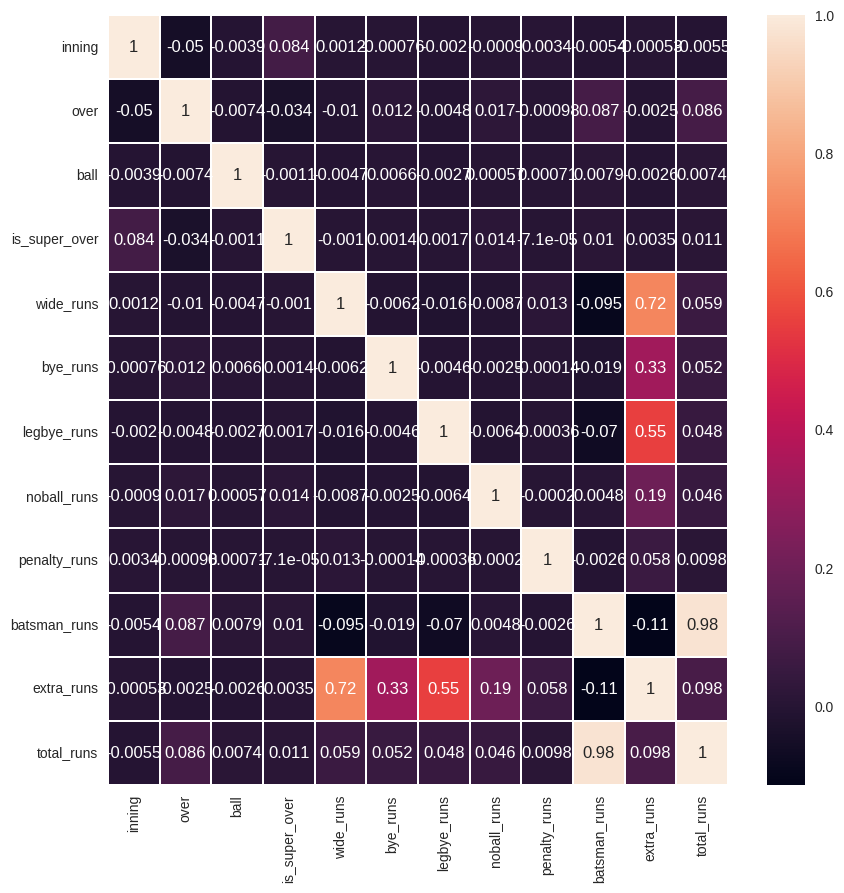

In [119]:
# dropping non-numeric columns
numeric_data = data2.select_dtypes(include=['float64', 'int64'])

# correlation matrix
corr = numeric_data.corr()

# plotting heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, linewidths=0.05)
plt.show()